![IonQ Logo](logo.png)
# IonQ iQuHack2025 Challenge



Before proceeding, register once.  Then, comment out the registration function call to avoid re-registering when running the notebook again.

In [73]:
import requests

def register():
    team_name = input("Enter your team name: ")
    in_person = input("Enter participation type - in-person or remote: ")
    data = []
    
    while email := input("Enter email separated by commas (enter to cancel): "):
        firstname = input("Enter your first name: ")
        lastname = input("Enter your last name: ")
        github = input("Enter your github handle: ")
        data.append((firstname, lastname, email, github))
    
    for firstname, lastname, email, github in data:
    	url = f"https://ionquhack2025.azurewebsites.net/api/registration?TeamName={team_name}&FirstName={firstname}&LastName={lastname}&Email={email}&GitHubHandle={github}&Remote-In-Person={in_person}"
    	req = requests.post(url)
    	print("\n\n\n"+req.text)


# Comment this out after registration:
#register()

Enter the `key` you've got on the previous step here:

In [74]:
key = "0302e6bb0c8cc785da5cd20513d82e1cae916c57b14e347baae26ea3dbf8489e"

Did you comment out the `register()` function call?  

Please share your research process on GitHub: https://github.com/iQuHACK/2025-IonQ/discussions


## DUQS' idea

Since we need to reduce the number of entangling gates, we decided to visit the graphs with a DFS algorithm to define a spanning tree (or forest). This way, the number of CX gates applied to the circuit is reduced to $n-1$, where $n = |V|$.

## Maximum Cut problem (max-cut) with variational Quantum Imaginary Time Evolution (varQITE) method

In this challenge, we demonstrate how to leverage
[IonQ Forte][1]'s industry-leading capabilities to solve instances of the
[NP-hard][2] combinatorial optimization problem known as
[Maximum Cut (MaxCut)][3] using a
[novel variational Quantum Imaginary Time Evolution (varQITE)][4] algorithm
developed by IonQ in conjunction with researchers at Oak Ridge National Labs
(ORNL).

[1]: https://ionq.com/forte
[2]: https://en.wikipedia.org/wiki/NP-hardness
[3]: https://en.wikipedia.org/wiki/Maximum_cut
[4]: https://arxiv.org/pdf/2404.16135

## What's the problem? 
### MaxCut 101

The Maximum Cut Problem (MaxCut) is a classic combinatorial optimization
problem commonly used as an algorithm benchmark by scientific computing
researchers. It has numerous applications in a variety of fields: for example,
it is used in circuit desing as part of Very Large Scale Integration (VLSI) to
find the optimal layout of circuit components; it is used in the study of
social networks to identify communities; it is used in computer vision for
image segmentation, etc.

**MaxCut is a graph problem**: given a graph $G = (V, E)$ with vertex set $V$ and
edge set $E$, it asks for a partition of $V$ into sets $S$ and $T$ maximizing
the number of edges crossing between $S$ and $T$.

Think of it like this: you're trying to cut the graph into two pieces, and you 
want to make the cut so that it slices through as many edges as possible.


# Prepare the code environment
First, we'll set up the coding environment and install necessary dependencies.

In [75]:
#pip install qiskit qiskit-aer networkx numpy pandas -q

To ensure your code runs correctly everywhere, please only use the imported dependencies.  Using external libraries may cause your submission to fail due to missing dependencies on our servers.

In [76]:
## IonQ, Inc., Copyright (c) 2025,
# All rights reserved.
# Use in source and binary forms of this software, without modification,
# is permitted solely for the purpose of activities associated with the IonQ
# Hackathon at iQuHack2025 hosted by MIT and only during the Feb 1-2, 2025 
# duration of such event.

import matplotlib.pyplot as plt
from IPython import display

import networkx as nx
import numpy as np
import pandas as pd
import time

from typing import List
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

# Graph definition

A simple graph, defined using the Python NetworkX library, will serve to illustrate the problem and you can explore further complexities.


In [77]:
# other graphs candidates to check

import networkx as nx
import matplotlib.pyplot as plt
import random

#-> Cycle Graph C8
def cycle_graph_c8():
    G = nx.cycle_graph(8)
    plt.figure(figsize=(6, 6))
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
    plt.title("Cycle Graph C8")
    plt.show()
    return G

# Path Graph P16
def path_graph_p16():
    G = nx.path_graph(16)
    plt.figure(figsize=(12, 2))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=300)
    plt.title("Path Graph P16")
    plt.show()
    return G

#-> Complete Bipartite Graph K8,8
def complete_bipartite_graph_k88():
    G = nx.complete_bipartite_graph(8, 8)
    plt.figure(figsize=(8, 6))
    pos = nx.bipartite_layout(G, nodes=range(8))
    nx.draw(G, pos, with_labels=True, node_color=['lightcoral'] * 8 + ['lightblue'] * 8,
            edge_color='gray', node_size=300)
    plt.title("Complete Bipartite Graph K8,8")
    plt.show()
    return G

#-> Complete Bipartite Graph K8,8
def complete_bipartite_graph_k_nn(n):
    G = nx.complete_bipartite_graph(n, n)
    plt.figure(figsize=(8, 6))
    pos = nx.bipartite_layout(G, nodes=range(n))
    nx.draw(G, pos, with_labels=True, node_color=['lightcoral'] * n + ['lightblue'] * n,
            edge_color='gray', node_size=300)
    plt.title("Complete Bipartite Graph K{},{}".format(n,n))
    plt.show()
    return G

# Star Graph S16
def star_graph_s16():
    G = nx.star_graph(16)
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='gold', edge_color='gray', node_size=300)
    plt.title("Star Graph S16")
    plt.show()
    return G

# Grid Graph 8x4
def grid_graph_8x4():
    G = nx.grid_graph(dim=[8, 4])
    plt.figure(figsize=(12, 6))
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300)
    plt.title("Grid Graph 8x4")
    plt.show()
    return G

# Grid Graph 8x4
def grid_graph_nxm(n,m):
    G = nx.grid_graph(dim=[n, m])
    plt.figure(figsize=(12, 6))
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300)
    plt.title("Grid Graph {}x{}".format(n,m))
    plt.show()
    return G


#-> 4-Regular Graph with 8 Vertices
def regular_graph_4_8():
    G = nx.random_regular_graph(d=4, n=8, seed=42)
    plt.figure(figsize=(6, 6))
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=500)
    plt.title("4-Regular Graph with 8 Vertices")
    plt.show()
    return G

#-> Cubic (3-Regular) Graph with 16 Vertices
def cubic_graph_3_16():
    G = nx.random_regular_graph(d=3, n=16, seed=42)
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightcoral', edge_color='gray', node_size=300)
    plt.title("Cubic (3-Regular) Graph with 16 Vertices")
    plt.show()
    return G

# Disjoint Union of Four C4 Cycles
def disjoint_union_c4():
    cycles = [nx.cycle_graph(4) for _ in range(4)]
    G = nx.disjoint_union_all(cycles)
    plt.figure(figsize=(12, 6))
    pos = {}
    shift_x = 0
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        pos_sub = nx.circular_layout(subgraph, scale=1, center=(shift_x, 0))
        pos.update(pos_sub)
        shift_x += 3
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300)
    plt.title("Disjoint Union of Four C4 Cycles")
    plt.show()
    return G

# Complete Bipartite Graph K16,16
def complete_bipartite_graph_k1616():
    G = nx.complete_bipartite_graph(16, 16)
    plt.figure(figsize=(12, 6))
    pos = nx.bipartite_layout(G, nodes=range(16))
    nx.draw(G, pos, with_labels=False, node_color=['lightcoral'] * 16 + ['lightblue'] * 16,
            edge_color='gray', node_size=100)
    plt.title("Complete Bipartite Graph K16,16")
    plt.show()
    return G

# 5-Dimensional Hypercube Graph Q5
def hypercube_graph_q5():
    G = nx.hypercube_graph(5)
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=False, node_color='lightgreen', edge_color='gray', node_size=200)
    plt.title("5-Dimensional Hypercube Graph Q5")
    plt.show()
    return G

# Tree Graph with 8 Vertices
def tree_graph_8():
    G = nx.balanced_tree(r=2, h=2)
    G.add_edge(6, 7)
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300)
    plt.title("Tree Graph with 8 Vertices")
    plt.show()
    return G

# Wheel Graph W16
def wheel_graph_w16():
    G = nx.wheel_graph(16)
    plt.figure(figsize=(8, 8))
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightcoral', edge_color='gray', node_size=300)
    plt.title("Wheel Graph W16")
    plt.show()
    return G

#-> Random Connected Graph with 16 Vertices
def random_connected_graph_16(p=0.15):
    #n, p = 16, 0.25
    n=16
    while True:
        G = nx.erdos_renyi_graph(n, p, seed=random.randint(1, 10000))
        if nx.is_connected(G):
            break
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=False, node_color='lightgreen', edge_color='gray', node_size=100)
    plt.title("Random Connected Graph with 16 Vertices")
    plt.show()
    return G

# Expander Graph with 32 Vertices
def expander_graph_32():
    G = nx.random_regular_graph(4, 32, seed=42)
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=100)
    plt.title("Expander Graph with 32 Vertices")
    plt.show()
    return G

#-> Expander Graph with n Vertices
def expander_graph_n(n):
    G = nx.random_regular_graph(4, n, seed=42)
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=100)
    plt.title("Expander Graph with {} Vertices".format(n))
    plt.show()
    return G

# Planar Connected Graph with 16 Vertices
def planar_connected_graph_16():
    G = nx.grid_graph(dim=[8, 2])
    G = nx.convert_node_labels_to_integers(G)
    additional_edges = [(0, 9), (1, 10), (2, 11), (3, 12), (4, 13), (5, 14), (6, 15),
                        (7, 15), (8, 7)]#, (6, 15), (14, 1), (1, 13), (10, 9), (0, 10), (12, 2), (8, 7)]
    G.add_edges_from([e for e in additional_edges if e[0] < 16 and e[1] < 16])
    assert nx.check_planarity(G)[0], "Graph is not planar."
    pos = {node: (node // 2, node % 2) for node in G.nodes()}
    plt.figure(figsize=(16, 8))
    nx.draw(G, pos, with_labels=False, node_color='lightcoral', edge_color='gray', node_size=100)
    plt.title("Planar Connected Graph with 16 Vertices")
    plt.axis('equal')
    plt.show()
    return G

We've suggested a few graph ideas above.  

The list below highlights those achievable with minimal computational resources, whether on a local laptop or a cloud instance. Some are simply too large.


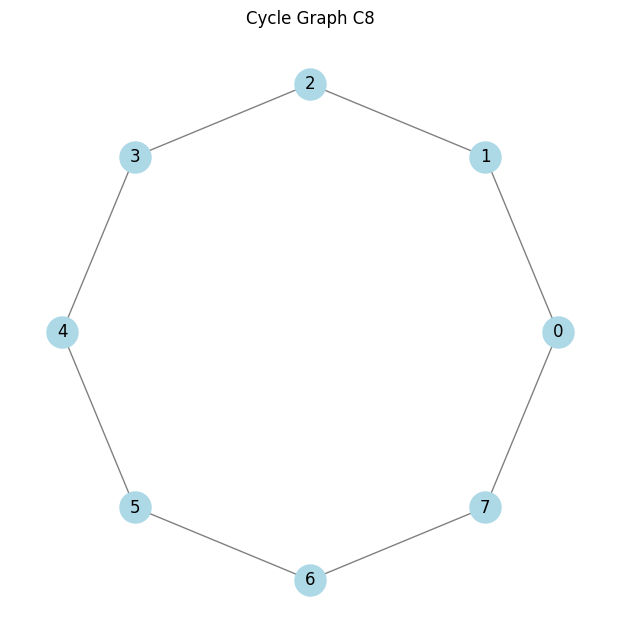

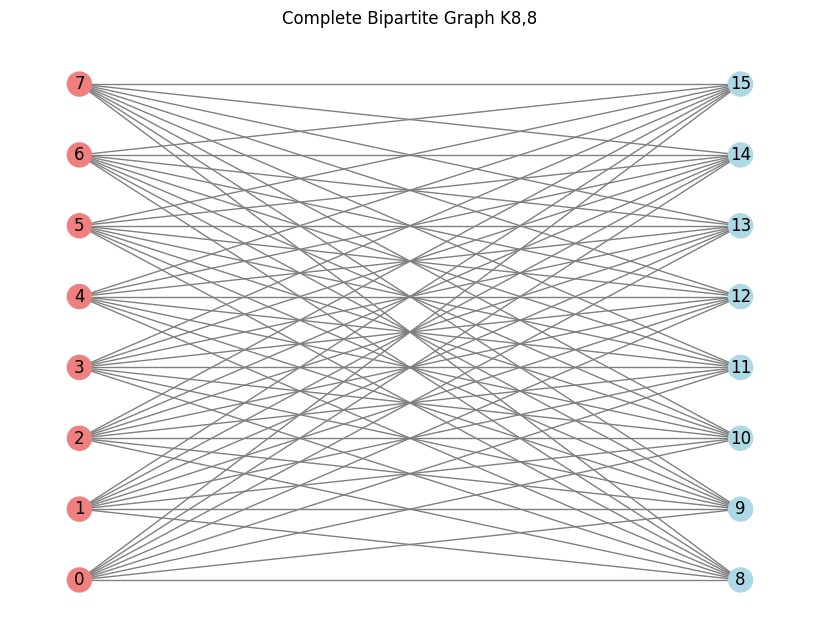

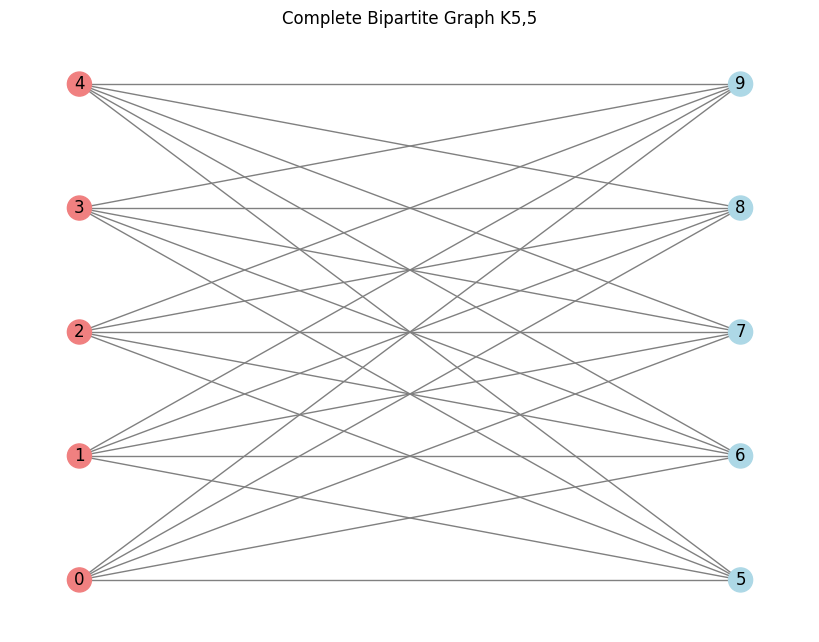

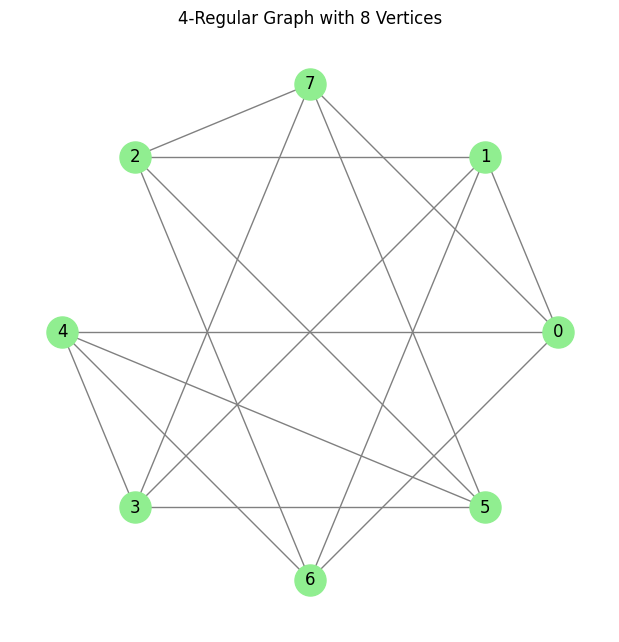

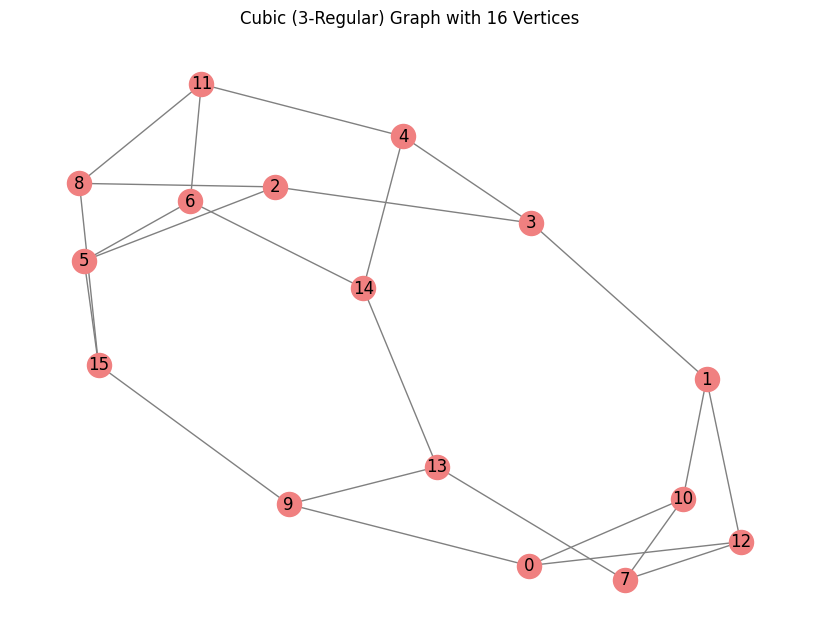

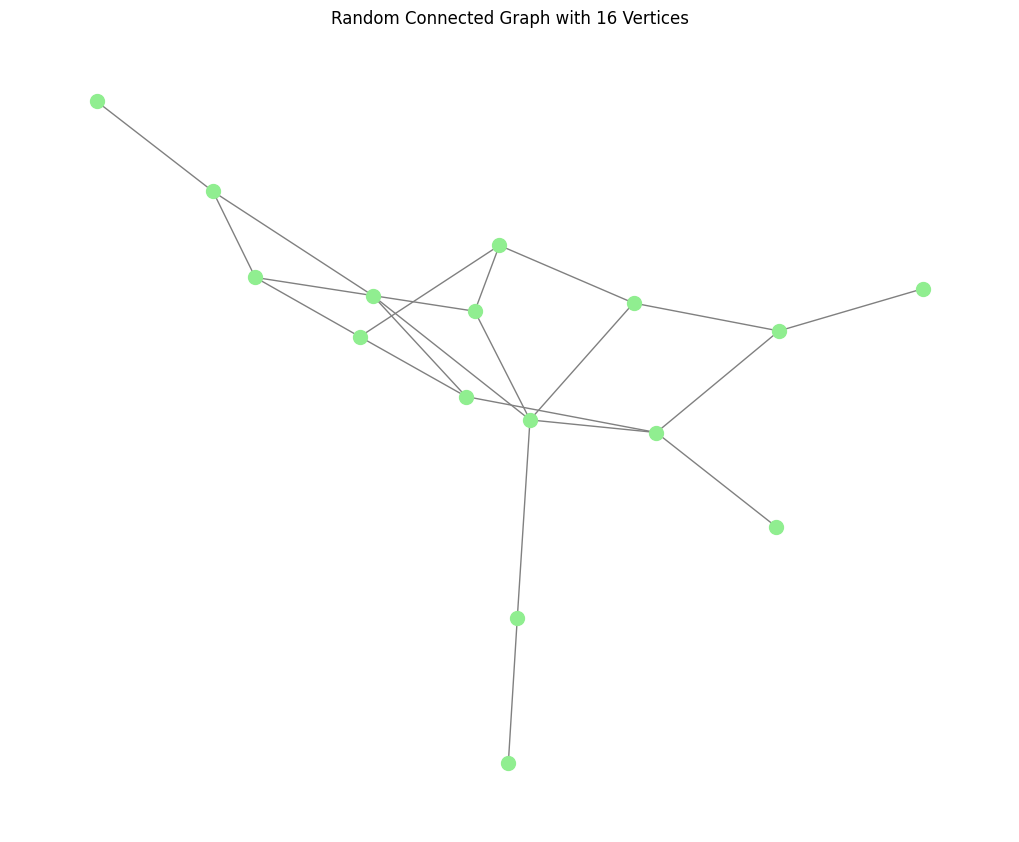

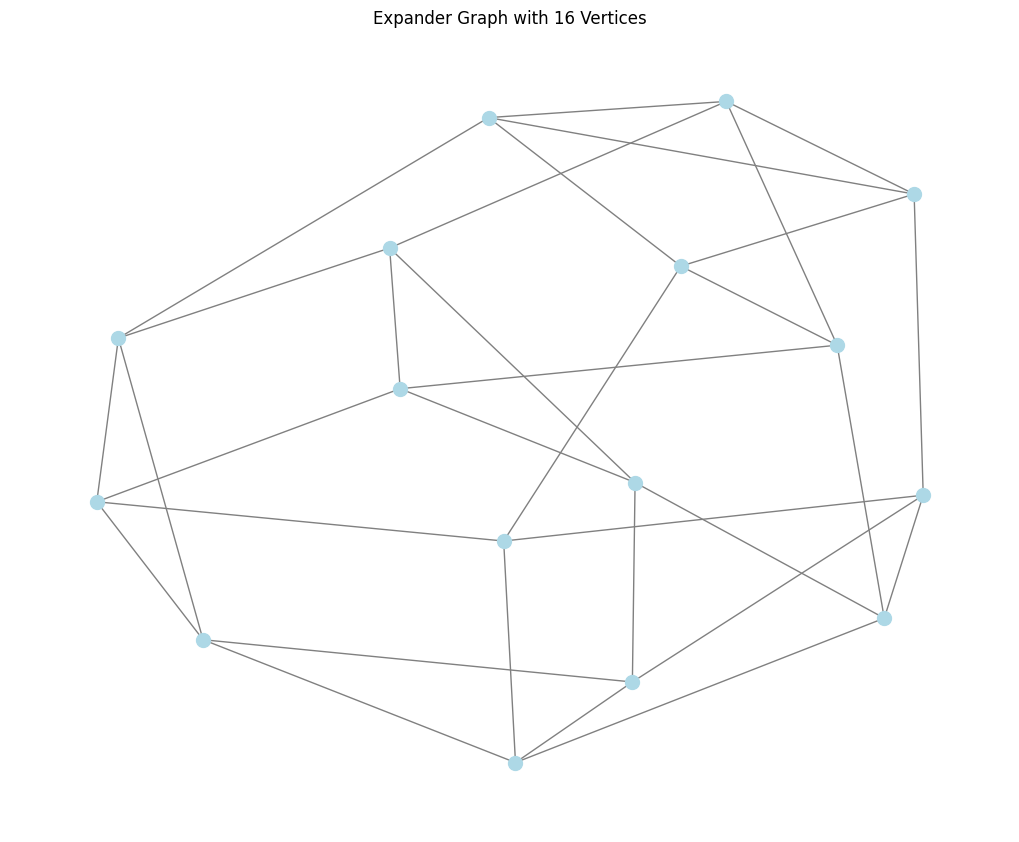

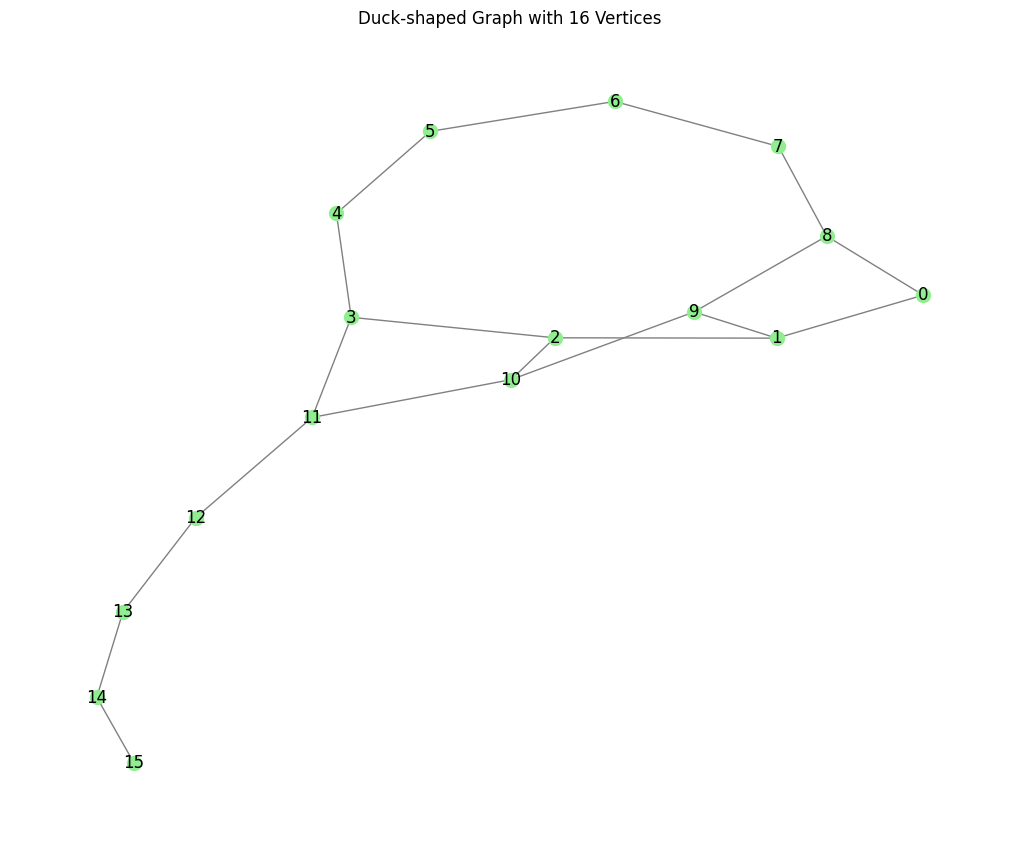

In [78]:
# Choose your favorite graph and build your winning ansatz!

graph1 = cycle_graph_c8() 
graph2 = complete_bipartite_graph_k88() 
graph3 = complete_bipartite_graph_k_nn(5) 
graph4 = regular_graph_4_8() 
graph5 = cubic_graph_3_16() 
graph6 = random_connected_graph_16(p=0.18)
graph7 = expander_graph_n(16) 
#graph8 = -> make your own cool graph

def duck_shaped_graph_16():
    G = nx.Graph()
    # Adding nodes for the duck shape
    nodes = range(16)
    G.add_nodes_from(nodes)

    edges = [
        (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7),
        (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13),
        (13, 14), (14, 15), (0, 8), (1, 9), (2, 10), (3, 11)
    ]
    G.add_edges_from(edges)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=100)
    plt.title("Duck-shaped Graph with 16 Vertices")
    plt.show()
    return G 
graph8 = duck_shaped_graph_16()

# Input graph

In [79]:
graph = graph4
graph

Play around with all of them

# Quantum Circuit Generator

We start by generating parameterized circuit based on a given graph.

🤔 Note: Future experiments will focus on optimizing this circuit generator (this function below).  Maximizing your score requires minimizing the number of gates in the generated parameterized circuit.

**Set of Rules:**

**Rules:**  Do not rename the function, import external libraries (except Qiskit), or use classical solvers. Implement any needed algorithms (e.g., sorting) within the function. Minimize gate count. Run locally for all the graphs before submitting the results.

Let's iterate again.

This challenge requires you to work within the provided function's name and scope.  You may only use Qiskit libraries.  Do not import additional libraries or call external functions.  If your solution requires operations like sorting, implement them directly within the function.  Critically, do *not* use a classical algorithm to solve the problem and simply input the result. Optimize your code to minimize the number of quantum gates, while aiming for the correct solutions distribution. Thoroughly get your solution results to report at the end.

**Important note:** To confirm your results, please save this notebook including all cell outputs and upload it in the form here: https://forms.gle/tAjnUd7b5t3oX3b2A . To avoid exceeding the notebook's 10MB file size limit, please be mindful of the number of print statements you use. Feel free to modify the notebook as needed. However, please ensure your code is readable. Please thoroughly comment your code; we will evaluate your problem-solving approach based on the educational clarity of your explanations.

Good luck, and have fun!


In [80]:
# Visualization will be performed in the cells below;
def build_ansatz(graph: nx.Graph) -> QuantumCircuit:

    ansatz = QuantumCircuit(graph.number_of_nodes())
    ansatz.h(range(graph.number_of_nodes()))

    #degrees = {node:val for (node, val) in graph.degree()}
    #root = min(degrees, key=degrees.get)
    root = random.randint(0,graph.number_of_nodes()-1)
    dfs_tree = nx.dfs_tree(graph, root)

    theta = ParameterVector(r"$\theta$", graph.number_of_edges())
    for t, (u, v) in zip(theta, dfs_tree.edges):
        ansatz.ry(t * np.pi/2, v)
        ansatz.cx(u, v)

    for i in range(graph.number_of_nodes()):
        ansatz.rz(np.pi/4, i)

    return ansatz


## On Parametrized Quantum Circuits

Parametrized quantum circuits (PQC) recently have gained significant attention as a prominent way to reach quantum advantage in many different fields. They are characterized by their use of varying parameters within quantum gates and can be optimized to solve specific problems, such as machine learning, quantum optimization, or quantum chemistry.

PQCs usually consist of three main parts:

1. Initialization: The qubits are set to a known starting state (usually $|0\rangle$) and then set into superposition with Hadamard gates.
2. Parameterized gates, such as rotation gates (Rx, Ry, Rz), and entanglement gates are adjustable.  Their parameters can be optimized to reflect the relationships between the encoded problem data.
3. Measurement: After applying the parameterized gates, the qubits are measured to get results.

These circuits are important elements in Variational Quantum Algorithms (VQA), hybrid quantum-classical systems where classical optimization helps to improve quantum operations. Two most notable examples of VQAs are Variational Quantum Eigensolver (VQE), an algorithm that finds a ground state energy of a given Hamiltonian, and Quantum Approximate Optimization Algorithm (QAOA), which is designed for solving combinatorial optimization problems. Near-term quantum computers are noisy and limited in size, and PQCs provide a practical way for us to use them more effectively.

More on that topic:
https://arxiv.org/abs/2207.06850

## Back to the problem in hand
This function produces parametrized quantum circuits (PQCs), a visualization of which is provided below.

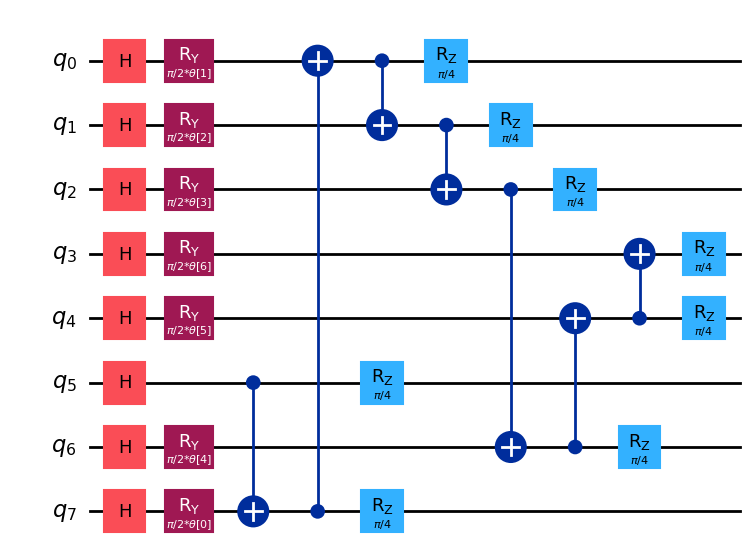

In [81]:
ansatz = build_ansatz(graph)
ansatz.draw("mpl", fold=-1)

# Building the MaxCut Hamiltonian

Formally, we write MaxCut as a [Quadratic Program (QP)][5] with binary
decision variables as follows. For each node $v \in V$, we let $x_v$ denote
a binary variable indicating whether $v$ belongs to $S$ or $T$. The objective
is to maximize the number of cut edges:
$$
    \text{maximize}_x\quad \sum_{(v, w) \in E} (x_v + x_w - 2 x_v x_w)
$$

Let's break this down. Notice that for each edge $e = (v, w)$ in the graph,
the quantity $(x_v + x_w - 2 x_v x_w)$ indicates whether $e$ is *cut* by the
partition represented by $x$; that is, the quantity $(x_v + x_w - 2 x_v x_w)$
is zero or one, and it equals one only if $v$ and $w$ lie on different sides of
the partition specified by $x$.

The code cell below obtains a symbolic representation of the maximization
objective corresponding to the graph above.

[5]: https://en.wikipedia.org/wiki/Quadratic_programming

In [82]:
def build_maxcut_hamiltonian(graph: nx.Graph) -> SparsePauliOp:
    """
    Build the MaxCut Hamiltonian for the given graph H_MC = -(|E|/2)*I + (1/2)*Σ_{(i,j)∈E}(Z_i Z_j)
    """
    num_qubits = len(graph.nodes)
    edges = list(graph.edges())
    num_edges = len(edges)

    pauli_terms = ["I"*num_qubits] # start with identity
    coeffs = [-num_edges / 2]

    for (u, v) in edges: # for each edge, add (1/2)*Z_i Z_j
        z_term = ["I"] * num_qubits
        z_term[u] = "Z"
        z_term[v] = "Z"
        pauli_terms.append("".join(z_term))
        coeffs.append(0.5)

    return SparsePauliOp.from_list(list(zip(pauli_terms, coeffs)))

Let's keep this function contained within its own cell, as you might need to adapt it for various max-cut problem types later.

In [83]:
ham = build_maxcut_hamiltonian(graph)
ham

SparsePauliOp(['IIIIIIII', 'ZZIIIIII', 'ZIIIIIIZ', 'ZIIIZIII', 'ZIIIIIZI', 'IZZIIIII', 'IZIIIIZI', 'IZIZIIII', 'IIZIIIIZ', 'IIIZIIIZ', 'IIIIIZIZ', 'IIZIIIZI', 'IIZIIZII', 'IIIZZIII', 'IIIIZIZI', 'IIIIZZII', 'IIIZIZII'],
              coeffs=[-8. +0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j])

## As a Hamiltonian energy minimization problem
### Quantum MaxCut

Quantum computers are good at finding the ground state of particle systems
evolving under the action of a given Hamiltonian. In this section, we'll
construct a Hamiltonian whose energies are exactly the values of the MaxCut
objective function. This correspondence will effectively translate our
classical combinatorial optimization problem into a quantum problem, which
we'll approach using our novel heuristic.

Given an objective function $C(x)$, with domain $x \in \{0, 1\}^n$, we'll
produce a Hamiltonian $H_C$ on $n$ qubits such that
$$
    H_C \ket{x} = C(x) \ket{x}.
$$
In the last equation, $\ket{x}$ denotes the $n$-qubit
[computational basis][10] state indexed by the bit-string $x \in \{0, 1\}$.
Thus the last equation says each of the $2^n$ computational basis states is an
eigenvector of $H_C$, and the eigenvalue corresponding to $\ket{x}$ is $C(x)$;
that is, $H_C$ is diagonal with respect to the computational basis, and its
energies are the values of the objective function $C$.

We'll obtain the Hamiltonian $H_C$ by replacing each $x_j$ in the expression of
$C(x)$ by the operator
$$
    \hat{X}_j \coloneqq \frac{1}{2}(I - Z_j),
$$
where $I$ denotes the identity operator on $n$ qubits and $Z_j$ denotes the
[Pauli-Z][11] operator acting on the $j$th qubit. Notice that $\hat{X}_j$ is
diagonal with respect to the computational basis, and its eigenvalues are zero
and one; in particular,
$$
    \hat{X}_j \ket{x} = x_j \ket{x}.
$$

### MaxCut Hamiltonian

When we apply the Ising map construction to the MaxCut objective
$$
    M(x) = \sum_{(v, w) \in E} (x_v + x_w - 2 x_v x_w)
$$
we obtain the Hamiltonian
$$
    H_M = \sum_{(v, w) \in E} (X_v + X_w - 2 X_v X_w) 
    = \frac{1}{2} \sum_{(v, w) \in E} \big(2 I - Z_v - Z_w - (I - Z_v)(I - Z_w)\big)
    = \frac{1}{2}|E| - \frac{1}{2} \sum_{(v, w) \in E} Z_v Z_w.
$$
In the last equation, $|E|$ denotes the number of edges in the graph.


[10]: https://en.wikipedia.org/wiki/Qubit#Standard_representation
[11]: https://en.wikipedia.org/wiki/Pauli_matrices

## Energy minimization via QITE
### Enter varQITE

With the MaxCut Hamiltonian in hand, we can turn to minimizing its energy using
our [novel quantum-classical varQITE heuristic][1]. Much like any Variataional
Quantum Algorithm (VQA), our novel varQITE method provides a recipe for
iteratively updating the parameters in a variational quantum circuit to
minimize the expectation value of the MaxCut Hamiltonian, measured with respect
to the parametrized state.

A key novelty is that our varQITE algorithm does *not* rely on a classical
optimizer to update the circuit parameters; instead, it specifies an explicit
update rule based on the solution of a system linear Ordinary Differential
Equations (ODEs). The ODEs relate the gradient of the variational circuit
parameters to the expected value of certain operators related to the MaxCut
Hamiltonian, and they are derived from an [Ehrenfest Theorem][3] that applies
to [imaginary time evolution][4]. For details, see Equation (5) in our [varQITE
paper][1].

In any case, setting up the ODE system at each step of the algorithm requires
executing a batch of quantum circuits and running some post-processing to
evaluate the results.

The code cell below illustrates how to set up the variational ansatz
$\ket{\Psi(\theta)}$ introduced by our [varQITE paper][1] in Equation (2).
We'll set up the required circuits and the ODEs further down.

[1]: https://arxiv.org/abs/2404.16135
[2]: https://www.nature.com/articles/s42254-021-00348-9
[3]: https://en.wikipedia.org/wiki/Ehrenfest_theorem
[4]: https://en.wikipedia.org/wiki/Imaginary_time

Below is simplified version of Quantum Imaginary Time Evolution (QITE). It uses a finite differences approach to estimate gradients, then performs gradient descent updates.

In [84]:
class QITEvolver:
    """
    A class to evolve a parametrized quantum state under the action of an Ising
    Hamiltonian according to the variational Quantum Imaginary Time Evolution
    (QITE) principle described in IonQ's latest joint paper with ORNL.
    """
    def __init__(self, hamiltonian: SparsePauliOp, ansatz: QuantumCircuit):
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz

        # Define some constants
        self.backend = AerSimulator()
        self.num_shots = 10000
        self.energies, self.param_vals, self.runtime = list(), list(), list()

    def evolve(self, num_steps: int, lr: float = 0.4, verbose: bool = True):
        """
        Evolve the variational quantum state encoded by ``self.ansatz`` under
        the action of ``self.hamiltonian`` according to varQITE.
        """
        curr_params = np.zeros(self.ansatz.num_parameters)
        for k in range(num_steps):
            # Get circuits and measure on backend
            iter_qc = self.get_iteration_circuits(curr_params)
            job = self.backend.run(iter_qc, shots=self.num_shots)
            q0 = time.time()
            measurements = job.result().get_counts()
            quantum_exec_time = time.time() - q0

            # Update parameters-- set up defining ODE and step forward
            Gmat, dvec, curr_energy = self.get_defining_ode(measurements)
            dcurr_params = np.linalg.lstsq(Gmat, dvec, rcond=1e-2)[0]
            curr_params += lr * dcurr_params

            # Progress checkpoint!
            if verbose:
                self.print_status(measurements)
            self.energies.append(curr_energy)
            self.param_vals.append(curr_params.copy())
            self.runtime.append(quantum_exec_time)

    def get_defining_ode(self, measurements: List[dict[str, int]]):
        """
        Construct the dynamics matrix and load vector defining the varQITE
        iteration.
        """
        # Load sampled bitstrings and corresponding frequencies into NumPy arrays
        dtype = np.dtype([("states", int, (self.ansatz.num_qubits,)), ("counts", "f")])
        measurements = [np.fromiter(map(lambda kv: (list(kv[0]), kv[1]), res.items()), dtype) for res in measurements]

        # Set up the dynamics matrix by computing the gradient of each Pauli word
        # with respect to each parameter in the ansatz using the parameter-shift rule
        pauli_terms = [SparsePauliOp(op) for op, _ in self.hamiltonian.label_iter() if set(op) != set("I")]
        Gmat = np.zeros((len(pauli_terms), self.ansatz.num_parameters))
        for i, pauli_word in enumerate(pauli_terms):
            for j, jth_pair in enumerate(zip(measurements[1::2], measurements[2::2])):
                for pm, pm_shift in enumerate(jth_pair):
                    Gmat[i, j] += (-1)**pm * expected_energy(pauli_word, pm_shift)
        
        # Set up the load vector
        curr_energy = expected_energy(self.hamiltonian, measurements[0])
        dvec = np.zeros(len(pauli_terms))
        for i, pauli_word in enumerate(pauli_terms):
            rhs_op_energies = get_ising_energies(pauli_word, measurements[0]["states"])
            rhs_op_energies *= get_ising_energies(self.hamiltonian, measurements[0]["states"]) - curr_energy
            dvec[i] = -np.dot(rhs_op_energies, measurements[0]["counts"]) / self.num_shots
        return Gmat, dvec, curr_energy

    def get_iteration_circuits(self, curr_params: np.array):
        """
        Get the bound circuits that need to be evaluated to step forward
        according to QITE.
        """
        # Use this circuit to estimate your Hamiltonian's expected value
        circuits = [self.ansatz.assign_parameters(curr_params)]

        # Use these circuits to compute gradients
        for k in np.arange(curr_params.shape[0]):
            for j in range(2):
                pm_shift = curr_params.copy()
                pm_shift[k] += (-1)**j * np.pi/2
                circuits += [self.ansatz.assign_parameters(pm_shift)]
        
        # Add measurement gates and return
        [qc.measure_all() for qc in circuits]
        return circuits
    
    def plot_convergence(self):
        """
        Plot the convergence of the expected value of ``self.hamiltonian`` with
        respect to the (imaginary) time steps.
        """
        plt.plot(self.energies)
        plt.xlabel("(Imaginary) Time step")
        plt.ylabel("Hamiltonian energy")
        plt.title("Convergence of the expected energy")

    def print_status(self, measurements):
        """
        Print summary statistics describing a QITE run.
        """
        stats = pd.DataFrame({
            "curr_energy": self.energies,
            "num_circuits": [len(measurements)] * len(self.energies),
            "quantum_exec_time": self.runtime 
        })
        stats.index.name = "step"
        display.clear_output(wait=True)
        display.display(stats)

A few utility functions:

In [85]:
def compute_cut_size(graph, bitstring):
    """
    Get the cut size of the partition of ``graph`` described by the given
    ``bitstring``.
    """
    cut_sz = 0
    for (u, v) in graph.edges:
        if bitstring[u] != bitstring[v]:
            cut_sz += 1
    return cut_sz

In [86]:
def get_ising_energies(
        operator: SparsePauliOp, 
        states: np.array
    ):
    """
    Get the energies of the given Ising ``operator`` that correspond to the
    given ``states``.
    """
    # Unroll Hamiltonian data into NumPy arrays
    paulis = np.array([list(ops) for ops, _ in operator.label_iter()]) != "I"
    coeffs = operator.coeffs.real
    
    # Vectorized energies computation
    energies = (-1) ** (states @ paulis.T) @ coeffs
    return energies

In [87]:
def expected_energy(
        hamiltonian: SparsePauliOp,
        measurements: np.array
):
    """
    Compute the expected energy of the given ``hamiltonian`` with respect to
    the observed ``measurement``.

    The latter is assumed to by a NumPy records array with fields ``states``
    --describing the observed bit-strings as an integer array-- and ``counts``,
    describing the corresponding observed frequency of each state.
    """
    energies = get_ising_energies(hamiltonian, measurements["states"])
    return np.dot(energies, measurements["counts"]) / measurements["counts"].sum()

In [88]:
def interpret_solution(graph, bitstring):
    """
    Visualize the given ``bitstring`` as a partition of the given ``graph``.
    """
    pos = nx.spring_layout(graph, seed=42)
    set_0 = [i for i, b in enumerate(bitstring) if b == '0']
    set_1 = [i for i, b in enumerate(bitstring) if b == '1']

    plt.figure(figsize=(4, 4))
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=set_0, node_color='blue', node_size=700)
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=set_1, node_color='red', node_size=700)

    cut_edges = []
    non_cut_edges = []
    for (u, v) in graph.edges:
        if bitstring[u] != bitstring[v]:
            cut_edges.append((u, v))
        else:
            non_cut_edges.append((u, v))

    nx.draw_networkx_edges(graph, pos=pos, edgelist=non_cut_edges, edge_color='gray', width=2)
    nx.draw_networkx_edges(graph, pos=pos, edgelist=cut_edges, edge_color='green', width=2, style='dashed')

    nx.draw_networkx_labels(graph, pos=pos, font_color='white', font_weight='bold')
    plt.axis('off')
    plt.show()

,curr_energy,num_circuits,quantum_exec_time
step,,,
0,-7.9948,15,0.386614
1,-7.9930,15,0.399176
2,-8.5554,15,0.380003
3,-8.9786,15,0.406971
4,-9.3108,15,0.384329
5,-9.6024,15,0.392166
6,-9.8660,15,0.386449
7,-10.1846,15,0.416341
8,-10.4190,15,0.395384


CPU times: total: 2min 56s
Wall time: 17.6 s


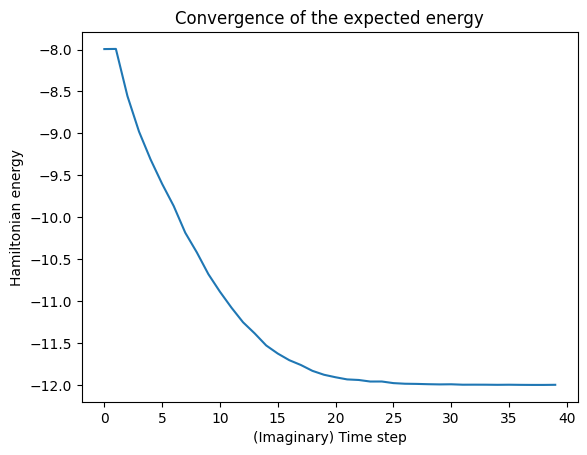

In [89]:
%%time

# Set up your QITEvolver and evolve!
qit_evolver = QITEvolver(ham, ansatz)
qit_evolver.evolve(num_steps=40, lr=0.1, verbose=True) # lr was 0.5

# Visualize your results!
qit_evolver.plot_convergence()

# Check out your best / most frequent cut!
Following the variational quantum imaginary time evolution (vQITE) loop, we sample the quantum circuit to obtain classical bitstrings.  The most frequent bitstring represents our solution, the final score though will take into account all of the right solutions...

In [90]:
from qiskit_aer import AerSimulator

shots = 100_000

# Sample your optimized quantum state using Aer
backend = AerSimulator()
optimized_state = ansatz.assign_parameters(qit_evolver.param_vals[-1])
optimized_state.measure_all()
counts = backend.run(optimized_state, shots=shots).result().get_counts()

# Find the sampled bitstring with the largest cut value
cut_vals = sorted(((bs, compute_cut_size(graph, bs)) for bs in counts), key=lambda t: t[1])
best_bs = cut_vals[-1][0]

# Now find the most likely MaxCut solution as sampled from your optimized state
# We'll leave this part up to you!!!
most_likely_soln = ""

print(counts)

{'01001111': 38418, '11101110': 1, '10111000': 11634, '10110000': 38167, '10101000': 1, '01000111': 11769, '00010011': 2, '01010111': 2, '01011111': 1, '11100110': 1, '00010001': 1, '10010000': 2, '11101100': 1}


C:\Users\sgala\AppData\Local\Temp\ipykernel_14124\3154274719.py:21: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(graph, pos=pos, edgelist=non_cut_edges, edge_color='gray', width=2)


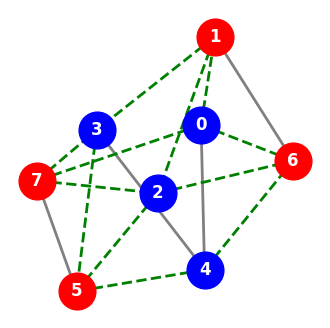

Cut value: 12
Graph with 8 nodes and 16 edges 01000111


In [91]:
interpret_solution(graph, best_bs)
print("Cut value: "+str(compute_cut_size(graph, best_bs)))
print(graph, best_bs)

# Drumroll please... the scores!


In [92]:
%%time
# Brute-force approach with conditional checks

verbose = False

G = graph
n = len(G.nodes())
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = 1.0
if verbose:
    print(w)

best_cost_brute = 0
best_cost_balanced = 0
best_cost_connected = 0

for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]

    # Create subgraphs based on the partition
    subgraph0 = G.subgraph([i for i, val in enumerate(x) if val == 0])
    subgraph1 = G.subgraph([i for i, val in enumerate(x) if val == 1])

    bs = "".join(str(i) for i in x)
    
    # Check if subgraphs are not empty
    if len(subgraph0.nodes) > 0 and len(subgraph1.nodes) > 0:
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + w[i, j] * x[i] * (1 - x[j])
        if best_cost_brute < cost:
            best_cost_brute = cost
            xbest_brute = x
            XS_brut = []
        if best_cost_brute == cost:
            XS_brut.append(bs)

        outstr = "case = " + str(x) + " cost = " + str(cost)

        if (len(subgraph1.nodes)-len(subgraph0.nodes))**2 <= 1:
            outstr += " balanced"
            if best_cost_balanced < cost:
                best_cost_balanced = cost
                xbest_balanced = x
                XS_balanced = []
            if best_cost_balanced == cost:
                XS_balanced.append(bs)

        if nx.is_connected(subgraph0) and nx.is_connected(subgraph1):
            outstr += " connected"
            if best_cost_connected < cost:
                best_cost_connected = cost
                xbest_connected = x
                XS_connected = []
            if best_cost_connected == cost:
                XS_connected.append(bs)
        if verbose:
            print(outstr)


CPU times: total: 31.2 ms
Wall time: 33.3 ms


C:\Users\sgala\AppData\Local\Temp\ipykernel_14124\3154274719.py:21: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(graph, pos=pos, edgelist=non_cut_edges, edge_color='gray', width=2)


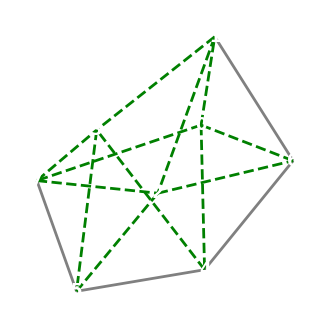

Graph with 8 nodes and 16 edges [1, 0, 1, 1, 0, 0, 0, 0]

Best solution = [1, 0, 1, 1, 0, 0, 0, 0] cost = 12.0
['10110000', '10111000', '10110100', '10110010', '10010110', '10110110', '01001001', '01101001', '01001101', '01001011', '01000111', '01001111']


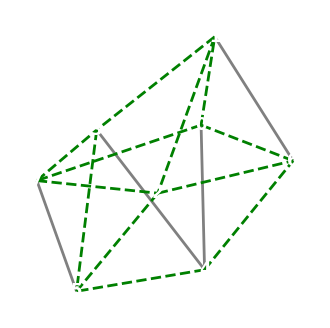

Graph with 8 nodes and 16 edges [1, 0, 1, 1, 1, 0, 0, 0]

Best balanced = [1, 0, 1, 1, 1, 0, 0, 0] cost = 12.0
['10111000', '10110100', '10110010', '10010110', '01101001', '01001101', '01001011', '01000111']


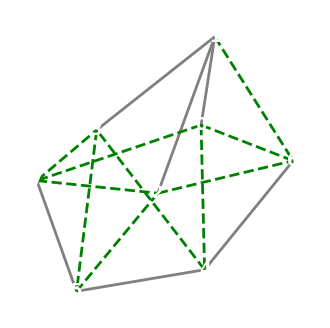

Graph with 8 nodes and 16 edges [1, 1, 1, 1, 0, 0, 0, 0]

Best connected = [1, 1, 1, 1, 0, 0, 0, 0] cost = 10.0
['11110000', '01111000', '11100100', '11010100', '11001100', '10101100', '01101100', '00111010', '10100110', '01010110', '00110110', '01001110', '10110001', '11001001', '10101001', '01011001', '11000101', '10010011', '01010011', '00110011', '00101011', '00011011', '10000111', '00001111']


In [93]:
# This is classical brute force solver results:
interpret_solution(graph, xbest_brute)
print(graph, xbest_brute)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))
print(XS_brut)

interpret_solution(graph, xbest_balanced)
print(graph, xbest_balanced)
print("\nBest balanced = " + str(xbest_balanced) + " cost = " + str(best_cost_balanced))
print(XS_balanced)

interpret_solution(graph, xbest_connected)
print(graph, xbest_connected)
print("\nBest connected = " + str(xbest_connected) + " cost = " + str(best_cost_connected))
print(XS_connected)
plt.show()

In [94]:
# And this is how we calculate the shots counted toward scores for each class of the problems

sum_counts = 0
for bs in counts:
    if bs in XS_brut:
        sum_counts += counts[bs]

print(f"Pure max-cut: {sum_counts} out of {shots}")

sum_balanced_counts = 0
for bs in counts:
    if bs in XS_balanced:
        sum_balanced_counts += counts[bs]

print(f"Balanced max-cut: {sum_balanced_counts} out of {shots}")

sum_connected_counts = 0
for bs in counts:
    if bs in XS_connected:
        sum_connected_counts += counts[bs]

print(f"Connected max-cut: {sum_connected_counts} out of {shots}")

Pure max-cut: 99988 out of 100000
Balanced max-cut: 23403 out of 100000
Connected max-cut: 0 out of 100000


In [95]:
def final_score(graph, XS_brut,counts,shots,ansatz,challenge):

    if(challenge=='base'):
        sum_counts = 0
        for bs in counts:
            if bs in XS_brut:
                sum_counts += counts[bs]
    elif(challenge=='balanced'):
        sum_balanced_counts = 0
        for bs in counts:
            if bs in XS_balanced:
                sum_balanced_counts += counts[bs]        
        sum_counts = sum_balanced_counts
    elif(challenge=='connected'):
        sum_connected_counts = 0
        for bs in counts:
            if bs in XS_connected:
                sum_connected_counts += counts[bs]
        sum_counts = sum_connected_counts

    
    transpiled_ansatz = transpile(ansatz, basis_gates = ['cx','rz','sx','x'])
    cx_count = transpiled_ansatz.count_ops()['cx']
    score = (4*2*graph.number_of_edges())/(4*2*graph.number_of_edges() + cx_count) * sum_counts/shots

    return np.round(score,5)

In [96]:
print("Base score: " + str(final_score(graph,XS_brut,counts,shots,ansatz,'base')))
print("Balanced score: " + str(final_score(graph,XS_brut,counts,shots,ansatz,'balanced')))
print("Connected score: " + str(final_score(graph,XS_brut,counts,shots,ansatz,'connected')))

Base score: 0.94803
Balanced score: 0.2219
Connected score: 0.0


This is the main challenge:  design optimal ansatz generators and Hamiltonians for the max-cut problem, subject to three specific conditions.  Solutions for each condition can be submitted independently; however, a unified approach applicable to all three conditions will receive additional credit.

# Submit your results

I guess this is the most important part. You probably want to report your results.

Please, follow the link: https://forms.gle/gkpSCe7HGr7QHZXQ6

Let's revisit the problem statement. **This is important!!!** We have three scoring methods to report:

1.  Counts shots achieving the optimal max-cut value. Sorry, no approximation value this time.
2.  Adds a balance constraint—subgraphs must have equal cardinality.
3.  Requires connected subgraphs—all vertices within a subgraph must be mutually reachable.

For **in-person participants**:  Prepare a presentation that explains your research and demonstrates the value of your proposed solution. You can modify any parts of the code, if you can defend your modifications during the presentation.

For **remote participants** (per Daiwei's comment in Discord channel):
@everyone, just summarize a few clarifications we just made.
1.  you are only suppose to change ansatz builder and hamiltonian builder function, without making any changes to the function signature. So we can do auto-grading.
2.  You should submit three notebook. One for each challenge. This way you don't need a argument to specify the challenge type in the ansatz and hamiltonian builder.
3.  We will push an update to the git page with all the anoucements and clarifications we did( will do) at 3pm today. ✅

Can you solve this?  Good luck!


# Feedback
If you have any suggestions or recommendations abou the hackathon challange, please, don't hesitatate to leave your comment here: https://iter.ly/u42um

![feedbackQR](feedbackQR.png)